In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [28]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os
import glob
import matplotlib

from src.data.loaders import get_loader
from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs
from sklearn.metrics import root_mean_squared_error, r2_score
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
path = './presentation/results/diagstromer/2024-12-02_14-13-12/'

In [17]:
# with open(os.path.join(path, 'pretraining', 'config.toml'), 'r') as file:
#     conf = toml.load(file)

In [16]:
pt_model, config = load_pt_model(os.path.join(path, 'pretraining'))

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated


## Finetuning results

In [30]:
from src.losses.rmse import custom_rmse

In [44]:
summary_data = []
for downstream_name in ['alcock', 'atlas']:
    for fold_n in range(3):
        test_loader = get_loader('./data/shared/records/{}/fold_{}/{}_100/test/'.format(downstream_name, fold_n, downstream_name),
                         batch_size=256,
                         window_size=config['window_size'],
                         probed_frac=0.,
                         random_frac=0.,
                         same_frac=0.,
                         sampling=True,
                         shuffle=False,
                         normalize='zero-mean',
                         repeat=0,
                         aversion=config['arch'],
                         num_cls=None,
                         cache=True)
        for spc in [20, 100, 500]:
            ft_path = os.path.join(path, 'finetuning', 
                                  downstream_name, 'fold_{}'.format(fold_n), 
                                  '{}_{}'.format(downstream_name, spc))
            ft_model, _ = load_pt_model(ft_path)
            ft_logs     = tensorboard_logs(ft_path)
            ft_time = ft_logs[-1]['wall_time'].iloc[-1] - ft_logs[-1]['wall_time'].iloc[0]

            pt_rmse_mean = 0
            ft_rmse_mean = 0
            count = 0
            for x, y in test_loader:               
                pt_pred = pt_model(x)
                ft_pred = ft_model(x)
                
                pt_rmse = custom_rmse(y['target'], pt_pred)
                ft_rmse = custom_rmse(y['target'], ft_pred)

                pt_rmse_mean+=pt_rmse
                ft_rmse_mean+=ft_rmse
                count+=1

            summary_data.append({
                'dataset': downstream_name,
                'spc': spc,
                'fold_n': fold_n,
                'pt_rmse':pt_rmse_mean.numpy()/count,
                'ft_rmse':ft_rmse_mean.numpy()/count,
                'ft_time':ft_time,
            })


[INFO] Probed: 0.00 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated
[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [45]:
summary_data

[{'dataset': 'alcock',
  'spc': 20,
  'fold_n': 0,
  'pt_rmse': 0.1618847688039144,
  'ft_rmse': 0.1776275634765625,
  'ft_time': 54.7403039932251}]

### Validation & Testing

In [186]:
y1_plot, y2_plot = [], []
for k, logs in enumerate(sorted_path):
    
    row = validation_metrics[k][validation_metrics[k]['rmse'].astype('float').values == validation_metrics[k]['rmse'].min()]
    y1_plot.append(float(row['rmse'].values[0]))
    if 'rsquare' not in validation_metrics[k].columns:
        y2_plot.append(0.8)
    else:
        y2_plot.append(float(row['rsquare'].values[0]))

In [187]:
x_plot  = np.array(sorted_labels)
y1_plot = np.array(y1_plot)
y2_plot = np.array(y2_plot)
test_metrics_pt = []
for i, path in enumerate(sorted_path):
    curr = os.path.join(path, 'results.csv')
    try:
        partial_df = pd.read_csv(curr)
    except:
        partial_df = pd.DataFrame({'test_mse': [0.], 'test_r2': [0.]})
        
    partial_df[TAG] = x_plot[i]        
    test_metrics_pt.append(partial_df)

test_metrics_pt = pd.concat(test_metrics_pt)  

In [188]:
df = pd.DataFrame()
df[TAG] = x_plot
df['val_rmse'] = y1_plot
df['val_r2'] = y2_plot
df_1 = test_metrics_pt[[TAG, 'test_mse', 'test_r2']]
df_2 = pd.merge(df, df_1, on=TAG)
df_2 = df_2.round(3)
df_2

,diagstromer,val_rmse,val_r2,test_mse,test_r2
0,v1,0.051,0.732,0.113,0.727
1,v1.5,0.057,0.690,0.000,0.000


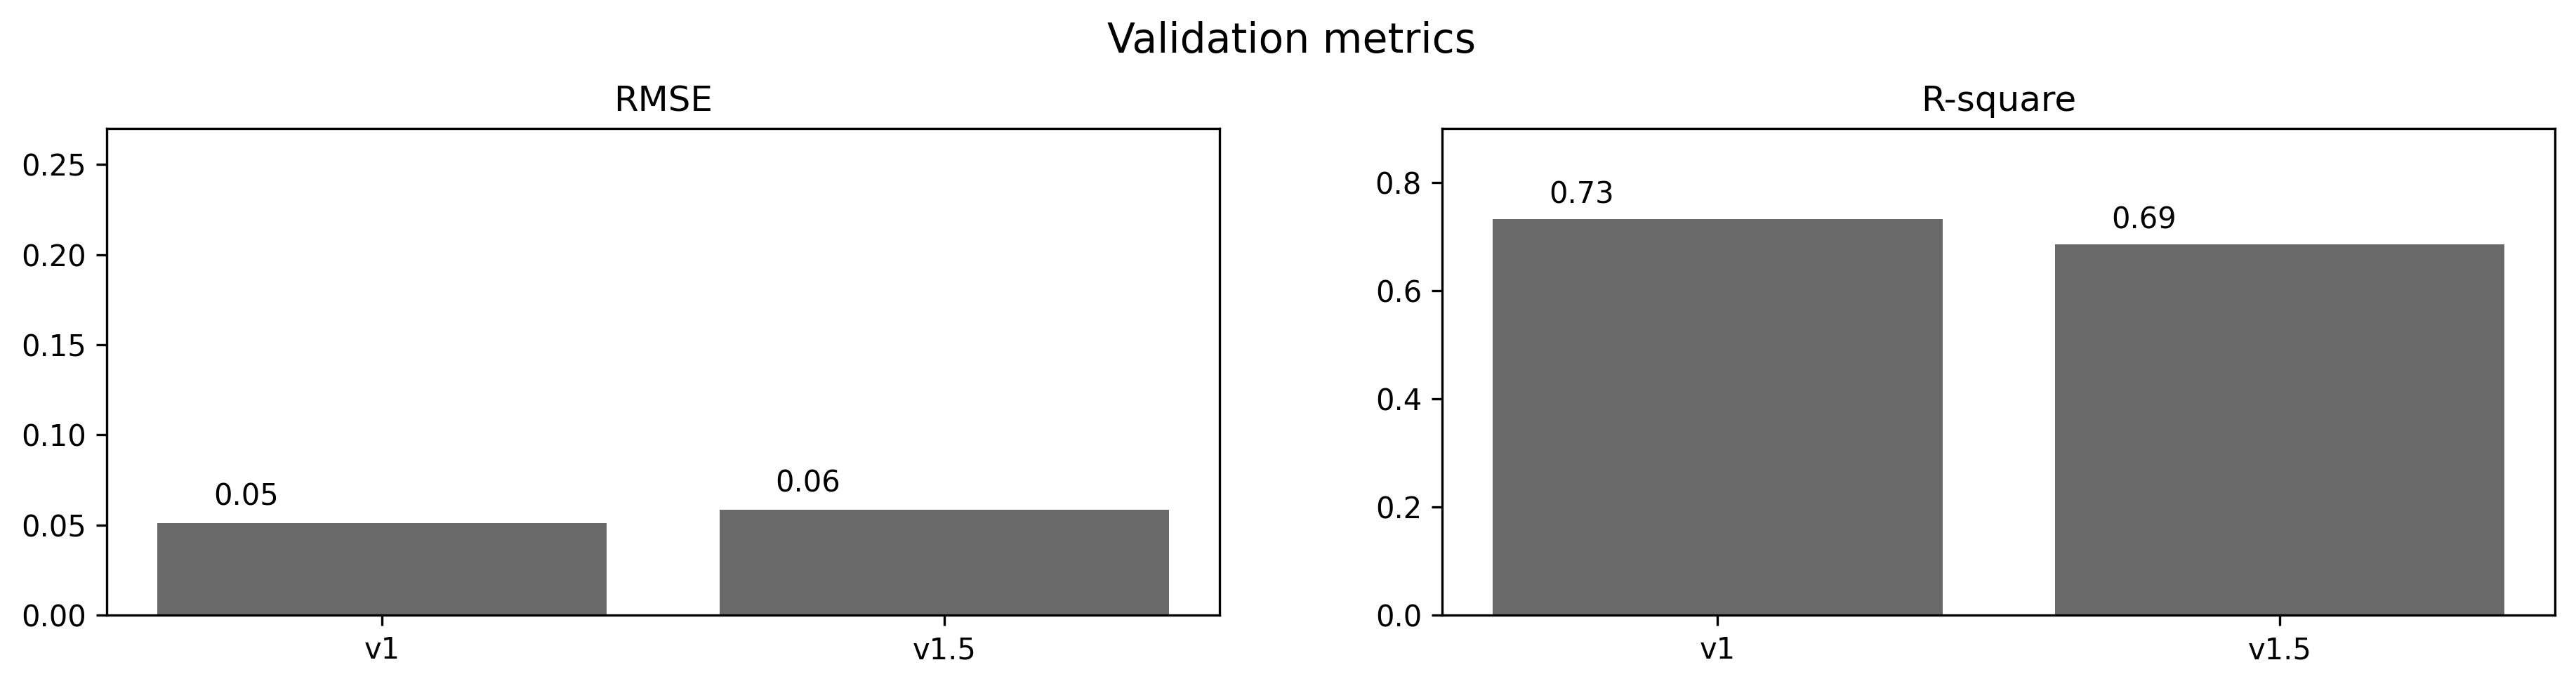

In [156]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))

xticks = range(len(x_plot))
axes[0].bar(xticks, y1_plot, color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.27)


for i, value in enumerate(y1_plot):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, y2_plot, color='dimgray')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot, rotation=0)
for i, value in enumerate(y2_plot):
    if i < 2 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))

axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.1, 0.90)
else:
    axes[1].set_ylim(-0., 0.90)

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'ckpt':
    fig.text(0.5, -0.03, r'Checkpoint epoch', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)

os.makedirs('./presentation/figures/htune/{}'.format(TAG), exist_ok=True)
fig.savefig('./presentation/figures/htune/{}/val.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show()

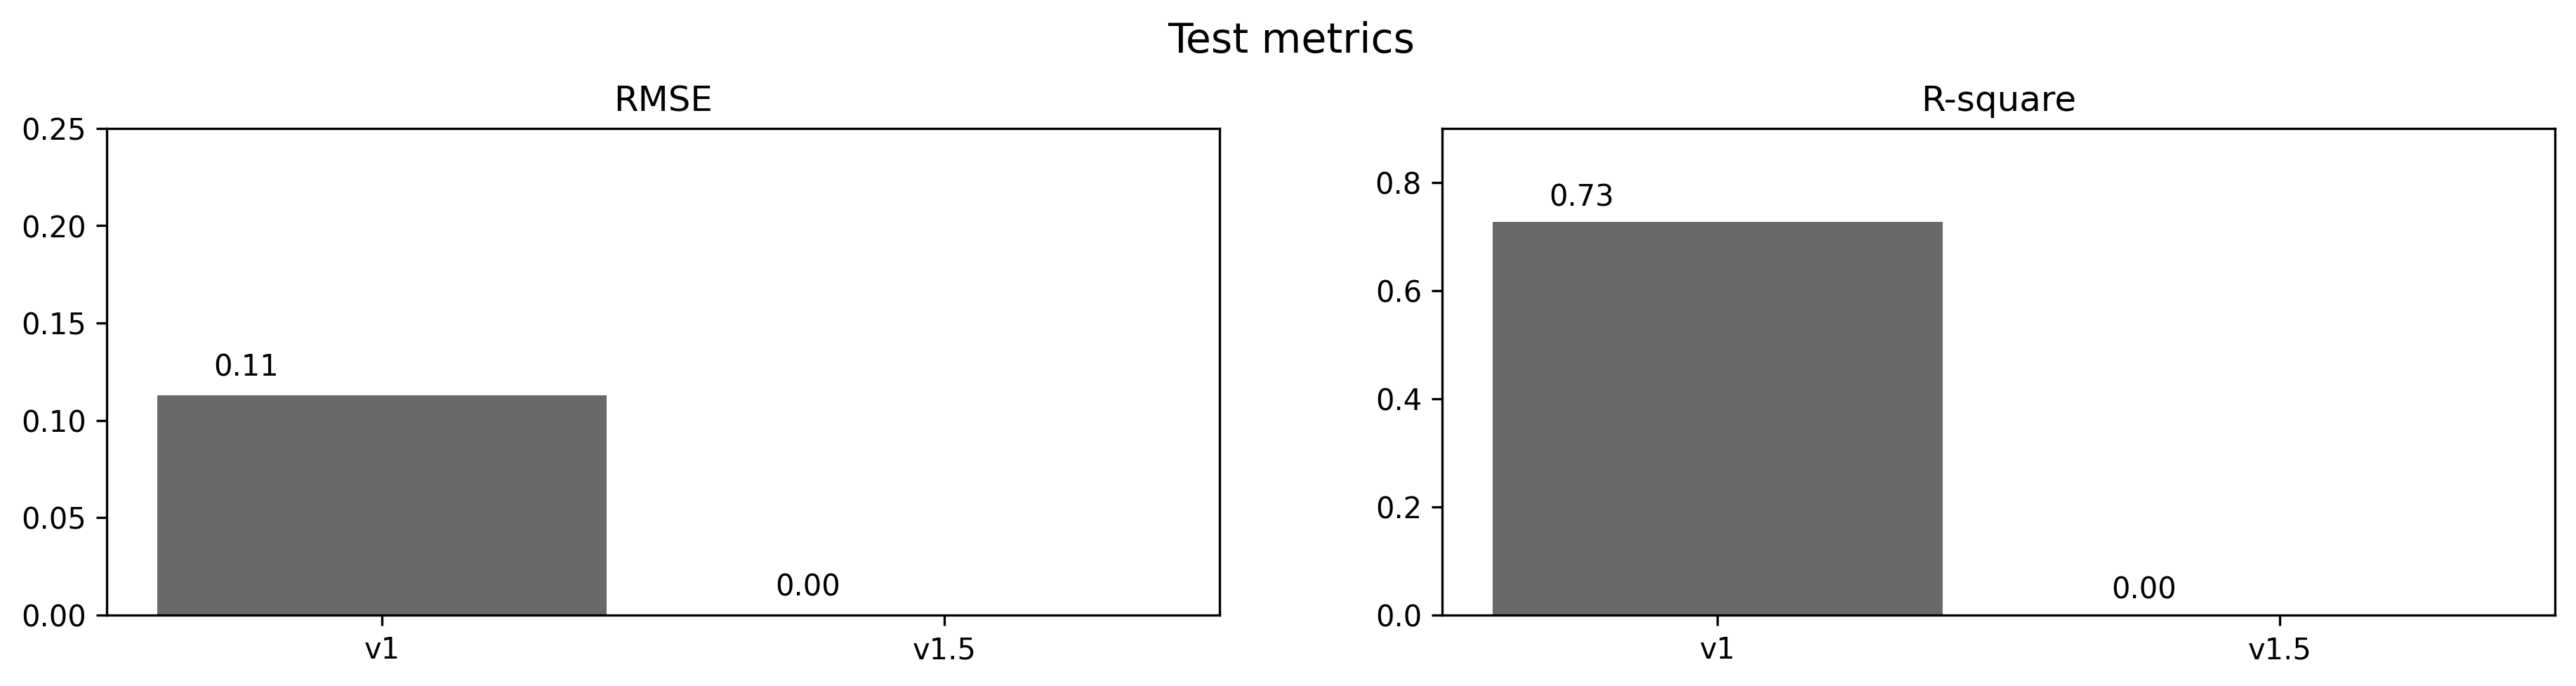

In [157]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))

axes[0].bar(xticks, test_metrics_pt['test_mse'], color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.25)

for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='dimgray')
axes[1].set_xticks(xticks)

axes[1].set_xticklabels(x_plot, rotation=0)

for i, value in enumerate(test_metrics_pt['test_r2']):
    if i < 2 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))
    
axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.1, 0.87)
else:
    axes[1].set_ylim(-0., 0.90)

fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)
    
fig.savefig('./presentation/figures/htune/{}/test.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show() 

### Classification

In [102]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [103]:
paper = classification_metrics(os.path.join('./presentation/results/paper/'), 
                               spc_list=[20, 100, 500], clf_arch='avg_mlp')

paper_new = classification_metrics(os.path.join('./presentation/results/paper/'), 
                               spc_list=[20, 100, 500], clf_arch='skip_avg_mlp')

paper_new['label'] = ['v0-wCLF']*paper_new.shape[0]
paper['label'] = ['Donoso\net.al\n(2023)']*paper.shape[0]

In [104]:
test_metrics = [] 
for i, root in enumerate(sorted_path):
    try:
        curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500], clf_arch='skip_avg_mlp')
        curr['label'] = [x_plot[i]]*curr.shape[0]
        test_metrics.append(curr)
    except Exception as e:
        pass
test_metrics = pd.concat(test_metrics)
test_metrics = pd.concat([paper, paper_new, test_metrics])
test_metrics = test_metrics[~test_metrics['mean'].isna()]

/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/users/cdonoso/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [128]:
plotconfig = {
    'diagstromer': {
        'ylim': {'alcock': (0.45, 0.8), 'atlas': (0.45, 0.85)},
        'xlabel': {'label':'Architecture', 'x':0.5, 'y':-0.15},
        'figsize':(10, 2.5)
    }
}

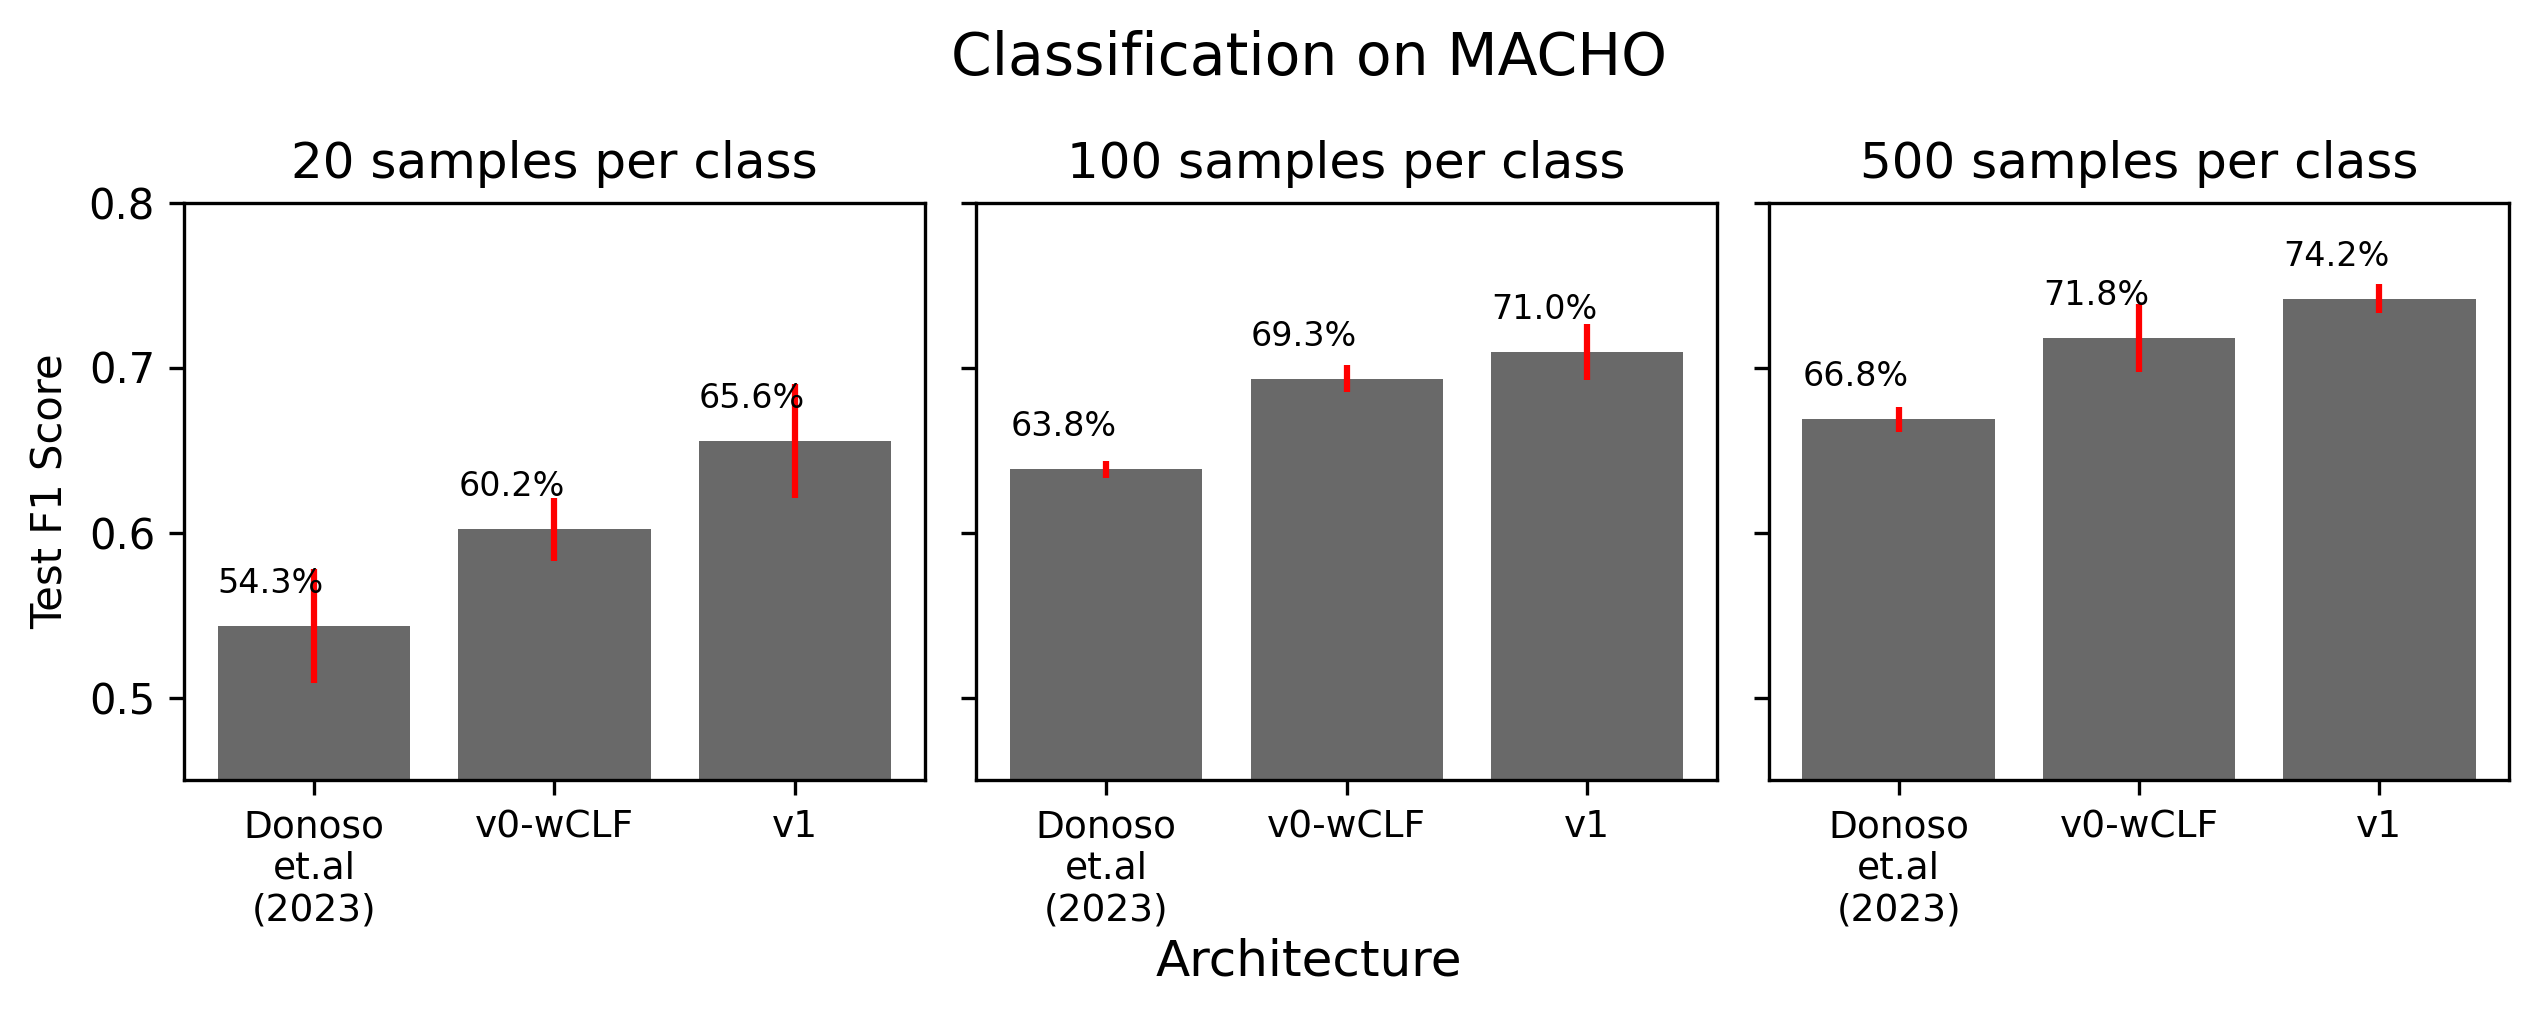

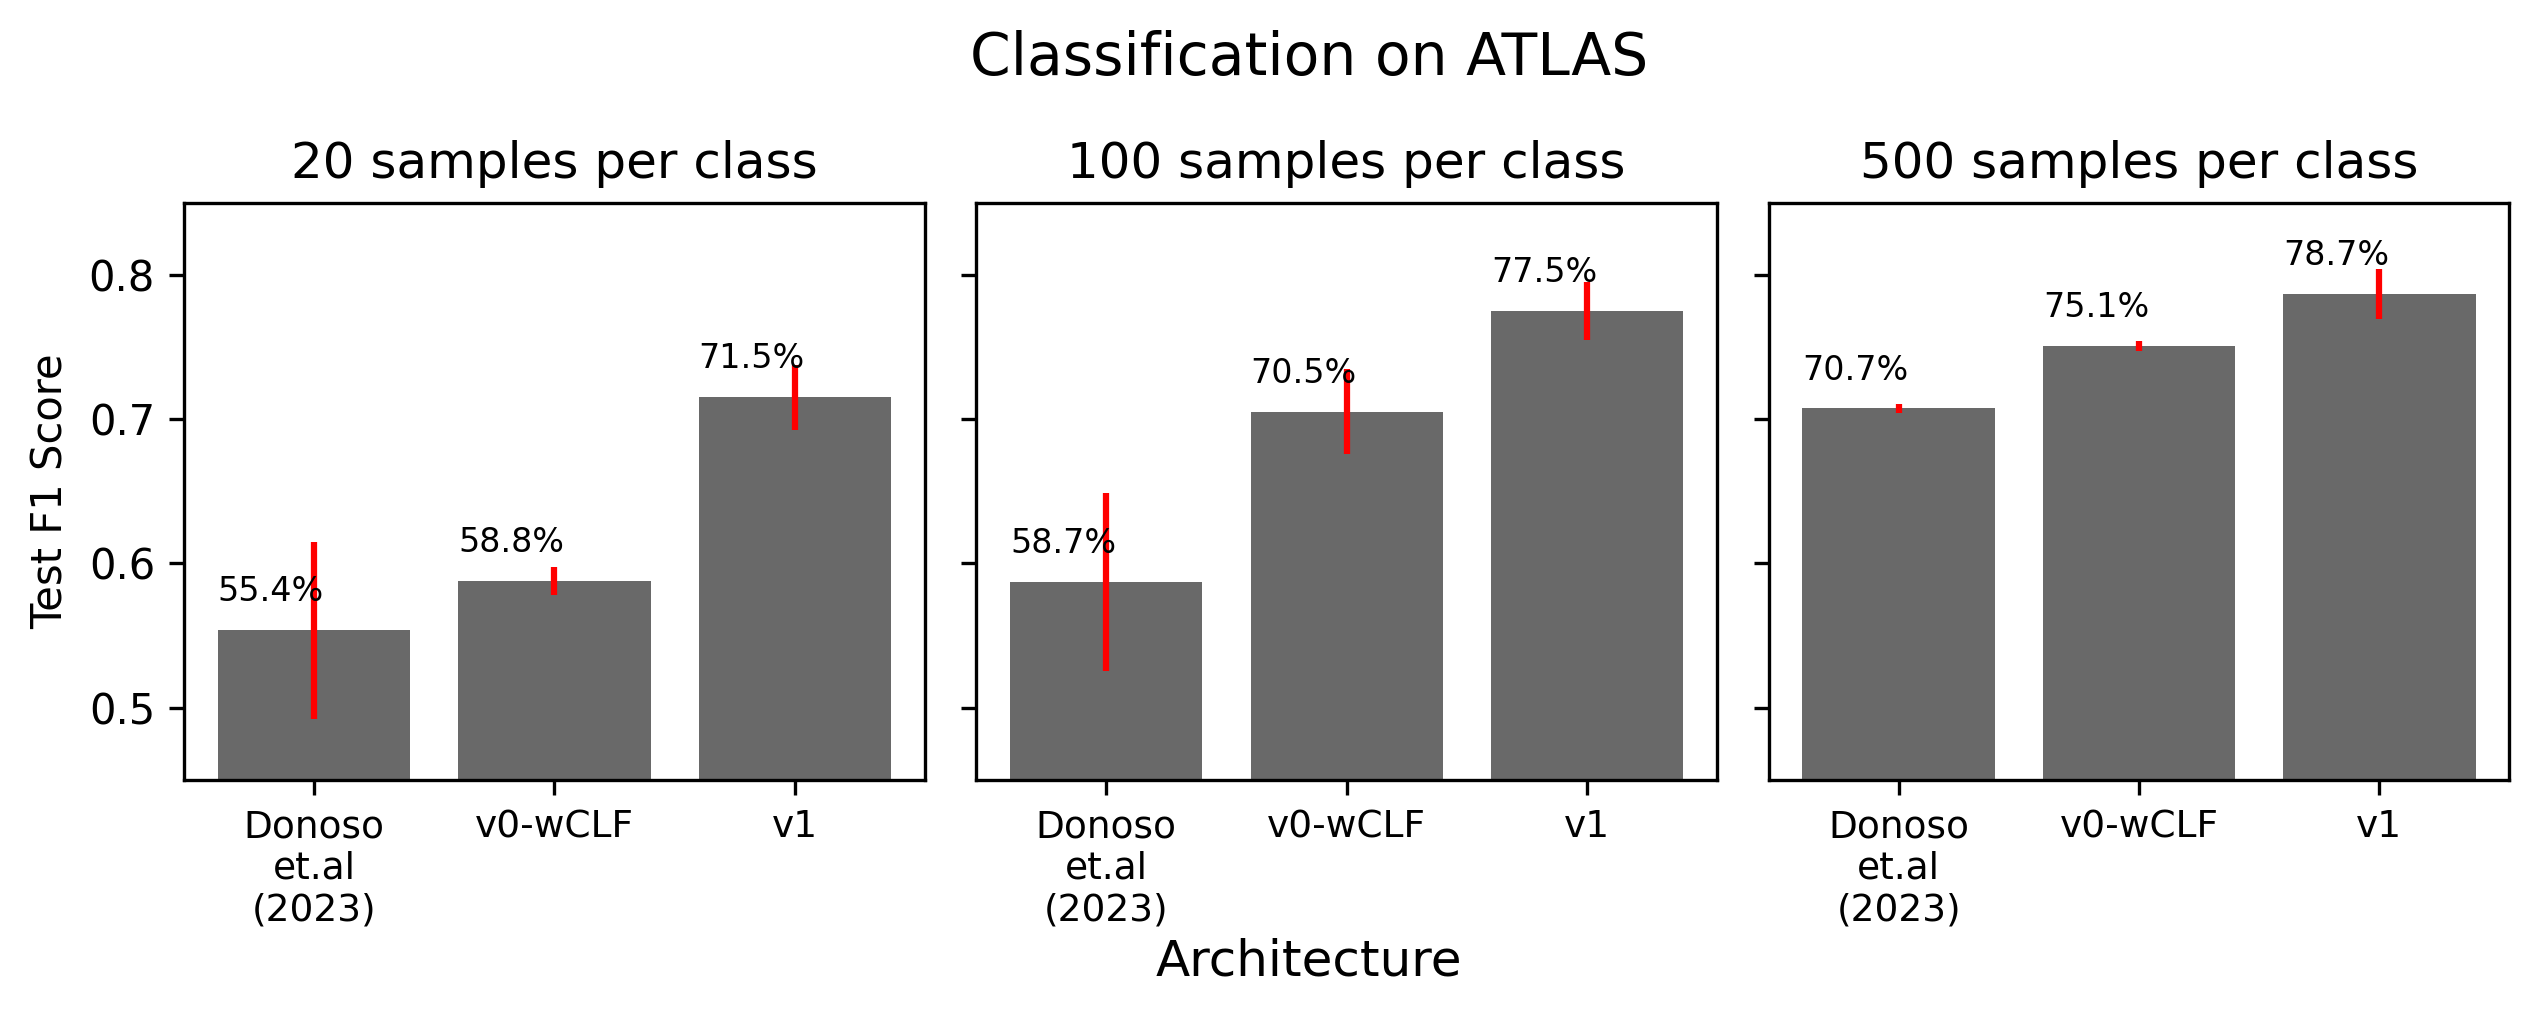

In [131]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=plotconfig[TAG]['figsize'], sharey=True, dpi=300, gridspec_kw={'wspace': 0.07})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):

        xticks = range(df1['label'].shape[0])
        xv = list(xticks)
        yv = df1['mean'].values
        ye = df1['std'].values
        
        axes[k].bar(xv, yv, yerr=ye, color='dimgray', ecolor='red')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(df1['label'].values, rotation=0, fontsize=9)
        axes[k].set_title('{} samples per class'.format(group1))
        axes[k].set_ylim(plotconfig[TAG]['ylim'][group0])
        
        for i, value in enumerate(df1['mean']):
            axes[k].text(i-0.4, value+0.02, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
    
    axes[0].set_ylabel('Test F1 Score', fontsize=10)
    # axes[0].legend(ncols=2)
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on ATLAS'
    fig.text(0.5, 1.05, title, ha='center', fontsize=14)
    fig.text(plotconfig[TAG]['xlabel']['x'], 
             plotconfig[TAG]['xlabel']['y'], 
             plotconfig[TAG]['xlabel']['label'], ha='center', fontsize=12)      
    
    os.makedirs('./presentation/figures/classification/{}'.format(TAG), exist_ok=True)
    fig.savefig('./presentation/figures/classification/{}/{}.pdf'.format(TAG, group0), format='pdf', bbox_inches='tight')  
    fig.savefig('./presentation/figures/classification/{}/{}.png'.format(TAG, group0), format='png', bbox_inches='tight')  

In [107]:
if TAG == 'ckpt':
    train_metrics, val_metrics = tensorboard_logs('./presentation/results/ckpt/epoch_0/pretraining/')
    
    
    for sset in ['alcock', 'atlas']:
        fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharey=True, gridspec_kw={'wspace': 0.3}, dpi=300)
        for i, SPC in enumerate([20, 100, 500]):
            test_selected = test_metrics[(test_metrics['spc'] == SPC) & (test_metrics['data'] == sset)][['ckpt', 'mean', 'std']]
            x = test_selected['ckpt'].astype(int)
            y = test_selected['mean']
            yerr = test_selected['std']
            
            
            ax[i].plot(val_metrics['step'], val_metrics['loss'], color='k')
            ax[i].set_ylabel('Validation RMSE')
            
            ax2 = ax[i].twinx()
            ax2.errorbar(x[:-1], y[:-1], yerr=yerr[:-1], marker='.', color='darkred')
            ax2.axhline(y=y.iloc[-1], color='darkgreen', linestyle='--', label='Best (epoch {})'.format(x.iloc[-1]))
            ax2.set_ylabel('F1 Score (3-fold mean)')
            ax2.set_xticks(x.iloc[:-1])
            ax[i].set_xticklabels(x.iloc[:-1], rotation=45)

            if sset == 'alcock':
                plt.title('MACHO \n{} samples per class'.format(SPC))
            if sset == 'atlas':
                plt.title('ATLAS \n{} samples per class'.format(SPC))
                
            lines1, labels1 = ax[i].get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax[i].legend(lines1 + lines2, labels1 + labels2, loc='center right')
        fig.savefig('./presentation/figures/clf_ckpt_{}.pdf'.format(sset), format='pdf', bbox_inches='tight')
    plt.show()